# Casos prácticos

En este notebook vamos a abordar dos casos prácticos interesantes.

1. Predicción (*forecasting*) de la demanda de bicicletas
2. Clasificación multiclase de imágenes

Lo primero es cargar las librerías y funciones necesarias.

In [3]:
from utils import plot_confusion_matrix

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1. Predicción de la demanda de bicicletas

El problema está descrito [aquí](https://christophm.github.io/interpretable-ml-book/bike-data.html), y los datos pueden descargarse en la [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), aunque los hemos modificado un poco para hacer el problema más parecido al [*challenge*](https://www.kaggle.com/c/bike-sharing-demand/data) original.

In [12]:
data = pd.read_csv('./data/bikes.csv',sep=';', decimal='.')
data.head()

,instant,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1-1-2011,1,0,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2-1-2011,1,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,3-1-2011,1,0,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,4-1-2011,1,0,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,5-1-2011,1,0,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


<div class = "alert alert-success">
EJERCICIO 9.1: Interpreta los datos y realiza tus primeras hipótesis sobre qué variables son de interés
</div>

<div class = "alert alert-success">
EJERCICIO 9.2: Elimina las columnas *instant*, *casual* y *registered*
</div>

In [13]:
# ... código aquí
data = data.drop(['instant', 'casual', 'registered'], axis=1)
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1-1-2011,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2-1-2011,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3-1-2011,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4-1-2011,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5-1-2011,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600


## 1.1 *Feature Engineering*

Vamos a trabajar con las fechas para crear algunas variables auxiliares. Podemos hacer esto con cualquier cadena de texto que represente una fecha, mediante la función `strptime` de Python y el ya conocido `apply` de Pandas.

In [15]:
data.tail()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
726,27-12-2012,1,0,1,2,0.254167,0.226642,0.652917,0.350133,2114
727,28-12-2012,1,0,1,2,0.253333,0.255046,0.590000,0.155471,3095
728,29-12-2012,1,0,0,2,0.253333,0.242400,0.752917,0.124383,1341
729,30-12-2012,1,0,0,1,0.255833,0.231700,0.483333,0.350754,1796
730,31-12-2012,1,0,1,2,0.215833,0.223487,0.577500,0.154846,2729


In [14]:
data.dtypes

dteday         object
season          int64
holiday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [16]:
from datetime import datetime

data['dteday'] = data['dteday'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [17]:
data.dtypes

dteday        datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

In [18]:
data['year'] = data['dteday'].apply(lambda x: x.year - 2011)
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


In [19]:
data['month'] = data['dteday'].apply(lambda x: x.month)
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1


In [20]:
data['weekday'] = data['dteday'].apply(lambda x: x.isoweekday())
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,weekday
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1,6
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1,7
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,1
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1,2
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1,3


Llegados a este punto, podemos eliminar la variable *dteday*

In [21]:
data = data.drop(['dteday'], axis=1)
data.head()

,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,weekday
0,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1,6
1,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1,7
2,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,1
3,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1,2
4,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1,3


## 1.2 Análisis de correlación

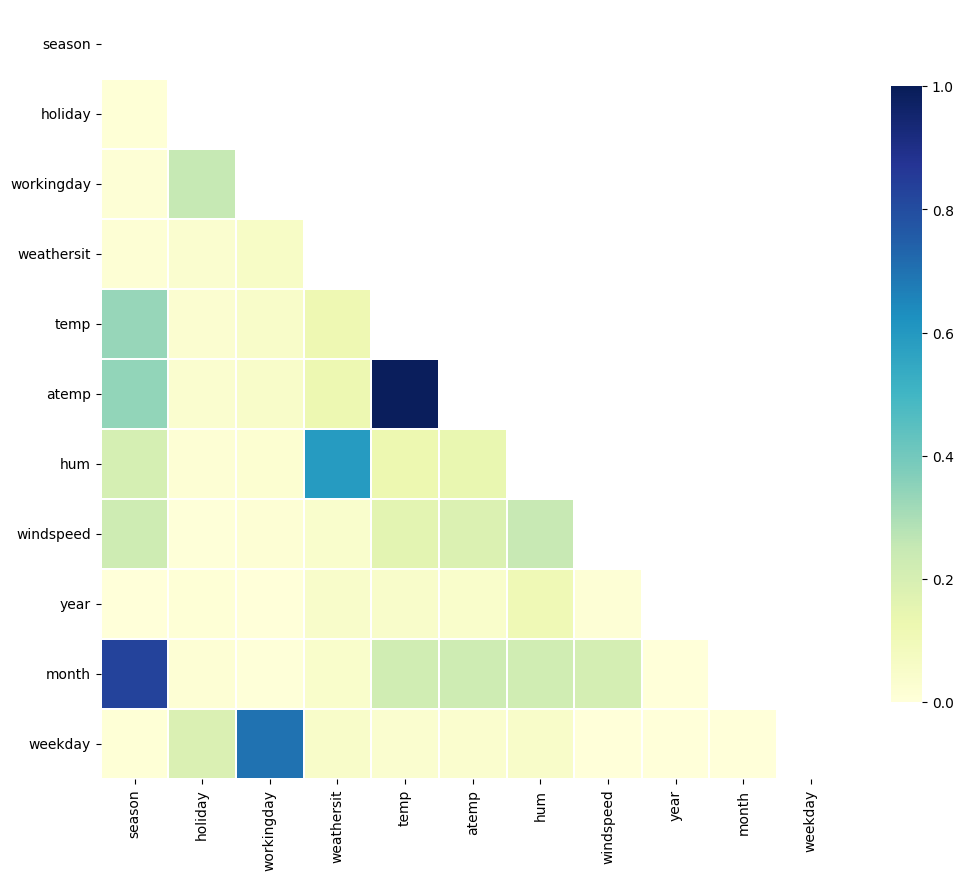

In [22]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['cnt'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

<div class = "alert alert-success">
EJERCICIO 9.3: Representa la variable *temp* vs *atemp*, por ejemplo mediante un scatter plot
</div>

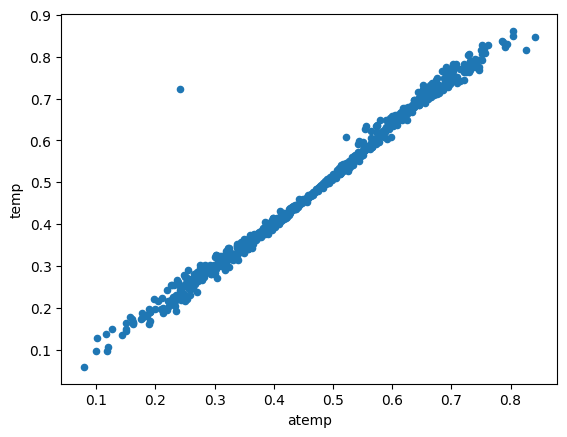

In [24]:
# ... código aquí
data.plot(kind = 'scatter',x='atemp',y = 'temp')
plt.xlabel('atemp')
plt.ylabel('temp')
plt.show()

A la vista está que son variables altamente correlacionadas. Podemos eliminar *temp*, ya que nos afecta más la sensación térmica que la temperatura real. O podemos eliminar *atemp*, si lo preferimos. Es una decisión del data scientist.

In [25]:
data = data.drop(['temp'], axis=1)
data.head()

,season,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,year,month,weekday
0,1,0,0,2,0.363625,0.805833,0.160446,985,0,1,6
1,1,0,0,2,0.353739,0.696087,0.248539,801,0,1,7
2,1,0,1,1,0.189405,0.437273,0.248309,1349,0,1,1
3,1,0,1,1,0.212122,0.590435,0.160296,1562,0,1,2
4,1,0,1,1,0.229270,0.436957,0.186900,1600,0,1,3


Podríamos seguir analizando de forma más exhaustiva, pero vamos a dejarlo aquí de momento.

## 1.3 Codificación de variables categóricas

Tenemos varias variables categóricas: *season*, *weathersit*, *month* y *weekday*. Cuando trabajamos con series temporales, es común crear variables *dummies* asociadas a cada una de las situaciones de las variables categóricas. Para ello, usamos get_dummies, que es básicamente el onehot de Pandas [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). Se aplica directamente sobre el dataframe puede [utilizarse](https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40) con strings directamente. La pega es que genera un nuevo dataframe que hay que agregar al original.

La codificación "dummy" de variables categóricas en problemas de clasificación/regresión es en general una mala idea, como vimos anteriormente, porque aumenta mucho la dimensionalidad de entrada; en series temporales resulta adecuado para explicar el efecto de una situación temporal en la variable target.

Comenzamos por la variable *season*. Veamos qué hace *get_dummies()*.

In [26]:
pd.get_dummies(data['season'], prefix = 'season')

,season_1,season_2,season_3,season_4
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False
...,...,...,...,...
726,True,False,False,False
727,True,False,False,False
728,True,False,False,False
729,True,False,False,False


In [27]:
dummy = pd.get_dummies(data['season'], prefix = 'season')

data = pd.concat([data,dummy],axis=1).drop(['season'],axis=1)
data.head()

,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,year,month,weekday,season_1,season_2,season_3,season_4
0,0,0,2,0.363625,0.805833,0.160446,985,0,1,6,True,False,False,False
1,0,0,2,0.353739,0.696087,0.248539,801,0,1,7,True,False,False,False
2,0,1,1,0.189405,0.437273,0.248309,1349,0,1,1,True,False,False,False
3,0,1,1,0.212122,0.590435,0.160296,1562,0,1,2,True,False,False,False
4,0,1,1,0.229270,0.436957,0.186900,1600,0,1,3,True,False,False,False


## 1.4 División train/test 

Sí, sí, habría que hacerla antes. Pido perdón (:

Vamos a ver cómo hacerla cuando tenemos datos con tendencia o estacionalidad, es decir, cuando hay componente temporal. No podemos aleatorizar alegremente, porque perderíamos ambas cosas; tenemos que escoger un punto a partir del cual consideraremos que los datos son de test.

In [28]:
# preparamos los datos
features = data.columns.drop(['cnt'])
X = data[features].values
y = data['cnt'].values

print('Filas, columnas', X.shape)

Filas, columnas (731, 13)


Vamos a escoger un offset que deje un 25% de los datos para test:

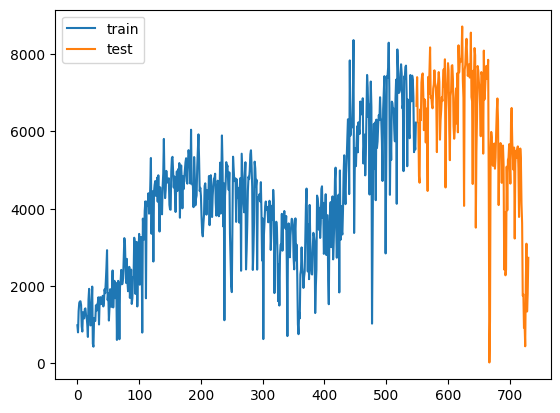

In [29]:
# Paso 1:
offset = 182 # 0.25 of 731

X_train = X[:-offset, :]
y_train = y[:-offset]
X_test  = X[-offset:, :]
y_test  = y[-offset:]

plt.plot(range(0,len(y_train)),y_train, label='train')
plt.plot(range(len(y_train),len(y)),y_test,label='test')
plt.legend()
plt.show()

## 1.5 Validación cruzada y búsqueda de parámetros libres

De nuevo, hay diferencias. La validación cruzada se hace con un objeto del tipo [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [30]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-4,4,20)
param_grid = {'alpha': alpha_vector}

grid = GridSearchCV(Lasso(), param_grid=param_grid, cv = TimeSeriesSplit(n_splits=3).split(X_train)).fit(X_train, y_train)

best parameters: {'alpha': 9.999999999999999e-05}


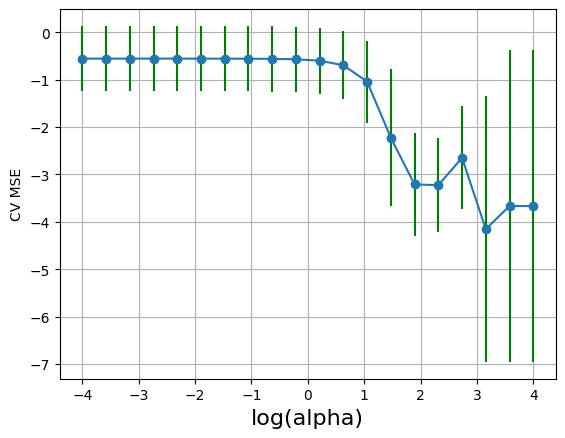

In [31]:
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.grid()
plt.show()

## 1.6 Métricas en test

Finalmente, calculamos el rendimiento del modelo.

In [32]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train,y_train)

ytrainLasso = lasso.predict(X_train)
ytestLasso  = lasso.predict(X_test)

mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

w = lasso.coef_
for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (train): 5e+05
MSE Modelo Lasso (test) : 1.4e+06
holiday -338.6105047333227
workingday 140.58802960419342
weathersit -526.7004734756268
atemp 5317.333754196536
hum -1302.5851009928676
windspeed -2587.517578179516
year 1968.8185371175869
month 47.09524256883534
weekday 31.711544353746422
season_1 -859.4283235251535
season_2 191.85256821819394
season_3 -338.2922200040177
season_4 163.48141010176124


<div class = "alert alert-success">
EJERCICIO 9.4: Representa la predicción obtenida junto con la serie real (train+test)
</div>

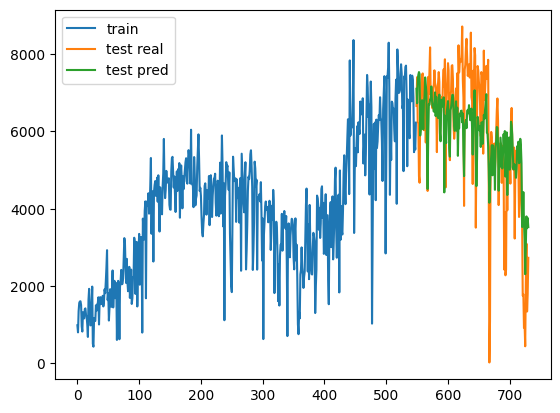

In [33]:
plt.plot(range(0,len(y_train)),y_train, label='train')
plt.plot(range(len(y_train),len(y)),y_test,label='test real')

# ... código aquí
plt.plot(range(len(y_train),len(y)),ytestLasso,label='test pred')

plt.legend()
plt.show()

# 2. Clasificación multiclase de imágenes

En este caso vamos a utilizar la famosa base de datos de [MNIST](http://yann.lecun.com/exdb/mnist/). Esta base de datos contiene

* Training set: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
* Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
* Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
* Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

Estas imágenes se pueden descargar a partir del siguiente código, asumiendo que tenéis los archivos (están en la carpeta `/data`):

In [4]:
import os
import gzip
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
        
    with gzip.open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, dtype=np.uint8).reshape(len(labels), 784).astype(np.float64)
 
    return images, labels

In [5]:
X_train, y_train = load_mnist('./data/mnist/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [6]:
X_test, y_test = load_mnist('./data/mnist/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


¡Fíjate que el conjunto de entrenamiento son los pixels de la imagen tal cual!

In [7]:
print ("X train shape: ", X_train.shape)
print ("y train shape: ", y_train.shape)
print ("X test shape: ",  X_test.shape)
print ("y test shape: ", y_test.shape)

X train shape:  (60000, 784)
y train shape:  (60000,)
X test shape:  (10000, 784)
y test shape:  (10000,)


<div class = "alert alert-success">
EJERCICIO 9.5: Entrena un modelo de regresión logística con C = 10 y calcula sus prestaciones en el conjunto de test. A lo mejor te resulta de utilidad revisar la [documentación](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
</div>

In [10]:
from sklearn.linear_model import LogisticRegression

# ... código aquí
lr = LogisticRegression(C=10, multi_class='multinomial').fit(X_train, y_train)

<div class = "alert alert-success">
EJERCICIO 9.6: Calcula y representa la matriz de confusión, ¿qué conclusiones puedes sacar?
</div>

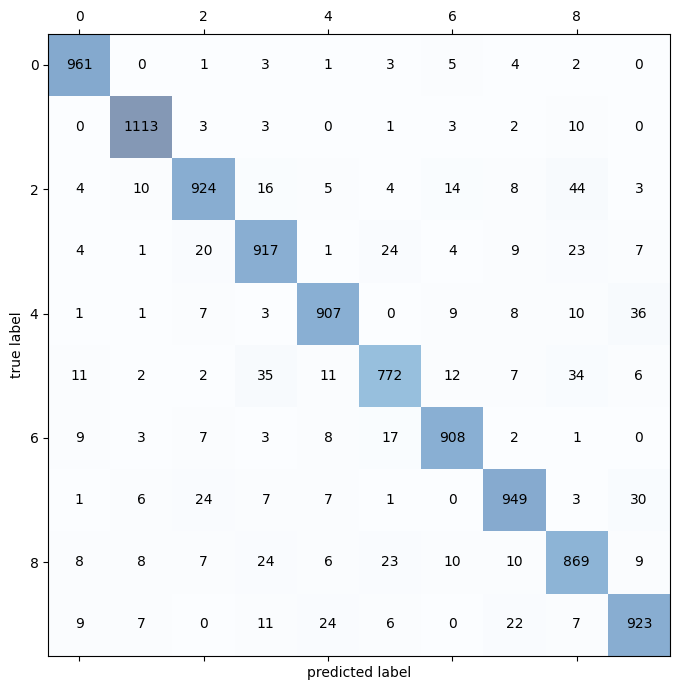

In [9]:
# WITHOUT MULTINOMIAL

from sklearn.metrics import confusion_matrix

# ... código aquí
y_pred_test = lr.predict(X_test)
confmat = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(confmat)

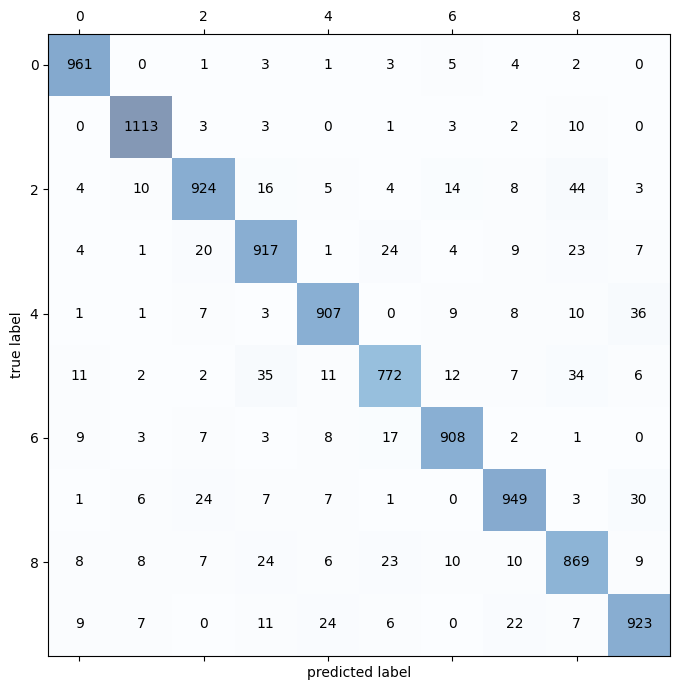

In [11]:
# WITH MULTINOMIAL

from sklearn.metrics import confusion_matrix

# ... código aquí
y_pred_test = lr.predict(X_test)
confmat = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(confmat)